**기본 세팅**

In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

mpl.rc('font', family='NanumGothic') # 폰트 설정
mpl.rc('axes', unicode_minus=False) # 유니코드에서 음수 부호 설정

# 차트 스타일 설정
sns.set(font="NanumGothic", rc={"axes.unicode_minus":False}, style='darkgrid')
plt.rc("figure", figsize=(10,8))

warnings.filterwarnings("ignore")

---

# 1. 가격 예측 데이터

실습 데이터는 캐글의 [Mercari Price Suggestion Challenge](https://www.kaggle.com/c/mercari-price-suggestion-challenge/data)를 사용한다.

이 데이터는 일본의 온라인 쇼핑몰 Mercari사의 제품에 대해 가격을 예측하는 과제이다.

**데이터 구조**

- train_id: 데이터 id


- name: 제품명


- item_condition_id: 판매자가 제공하는 제품 상태


- category_name: 카테고리 명


- brand_name: 브랜드 이름


- price: 제품 가격(타겟)


- shipping: 배송비 무료 여부, 1이면 무료(판매자 지불), 0이면 유료(구매자 지불)


- item_description: 제품에 대한 설명

## 1.1 데이터 전처리

In [3]:
mercari_df = pd.read_csv("mercari_train.tsv", sep="\t")
mercari_df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [4]:
mercari_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482531 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


- 데이터는 1,482,535 x 8로 이루어져 있다.


- category_name, brand_name, item_description의 경우 Null값이 존재한다.


- 특히 brand_name의 경우 Null값이 매우 많다.

### 1.1.1 피처 전처리

In [5]:
mercari_df["item_condition_id"].value_counts()

1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64

- item_condition_id의 경우 각 값의 의미는 캐글에 제공되어 있지 않다.


- 값 자체는 대부분 1,3,2에 몰려있으며 따로 수정할 필요는 없어 보인다.

In [6]:
mercari_df["category_name"].value_counts() 

Women/Athletic Apparel/Pants, Tights, Leggings    60177
Women/Tops & Blouses/T-Shirts                     46380
Beauty/Makeup/Face                                34335
Beauty/Makeup/Lips                                29910
Electronics/Video Games & Consoles/Games          26557
                                                  ...  
Home/Home Appliances/Dishwashers                      1
Handmade/Weddings/Frames                              1
Handmade/Housewares/Cleaning                          1
Handmade/Patterns/Embroidery                          1
Home/Furniture/Bathroom Furniture                     1
Name: category_name, Length: 1287, dtype: int64

- category_name은 "/"으로 대/중/소분류를 구분하고 있다.


- 이를 대/중/소로 컬럼을 나누도록 한다.


- 다만 category_name에는 Null값이 일부 있었으므로 이를 반영해서 나눈다.

In [7]:
# 대/중/소 분류 함수
def split_cat(category_name):
    # "/"을 기준으로 분리하되 Null 값은 Other_Null로 반환
    try:
        return category_name.split('/')
    except:
        return ['Other_Null' , 'Other_Null' , 'Other_Null']

# category_name 분리 (zip 함수안에 "*" 기억)
cat_dae, cat_jung, cat_so = zip(*mercari_df['category_name'].apply(lambda x : split_cat(x)))
mercari_df["cat_dae"] = cat_dae
mercari_df["cat_jung"] = cat_jung
mercari_df["cat_so"] = cat_so

- category_name을 분리하되 Null 값은 Other_Null로 변환한다.

In [8]:
print('대분류 유형 :')
print(mercari_df['cat_dae'].value_counts())

print('중분류 갯수 :', mercari_df['cat_jung'].nunique())
print('소분류 갯수 :', mercari_df['cat_so'].nunique())

대분류 유형 :
Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_Null                  6327
Name: cat_dae, dtype: int64
중분류 갯수 : 114
소분류 갯수 : 871


- 대분류의 경우 Women, Beauty, Kids, Electronics 등이 가장 많았다.


- 중분류, 소분류는 각각 114개, 871개로 구성되어 있다.

In [9]:
mercari_df["shipping"].value_counts() 

0    819435
1    663100
Name: shipping, dtype: int64

- shipping의 값은 거의 균일하게 분포되어 있다.

In [10]:
mercari_df["item_description"].value_counts()[0:1]

No description yet    82489
Name: item_description, dtype: int64

- item_description은 결측이 4건 밖에 없었다. 


- 하지만 별도 설명이 없는 경우 No description yet 값으로 82,489건이 존재한다.

In [11]:
# 결측은 모두 Other_Null
mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value='Other_Null')
mercari_df['category_name'] = mercari_df['category_name'].fillna(value='Other_Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna(value='Other_Null')

mercari_df.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
cat_dae              0
cat_jung             0
cat_so               0
dtype: int64

- brand_name은 결측이 너무 많았고 이를 대체할 적절한 값이 없다.


- 마찬가지로 다른 값들 역시 적절한 대체 값이 없어 모두 Other_Null로 변환한다.


- item_description의 No description yet은 우선 그냥 놔두었다.

### 1.1.2 타겟 전처리

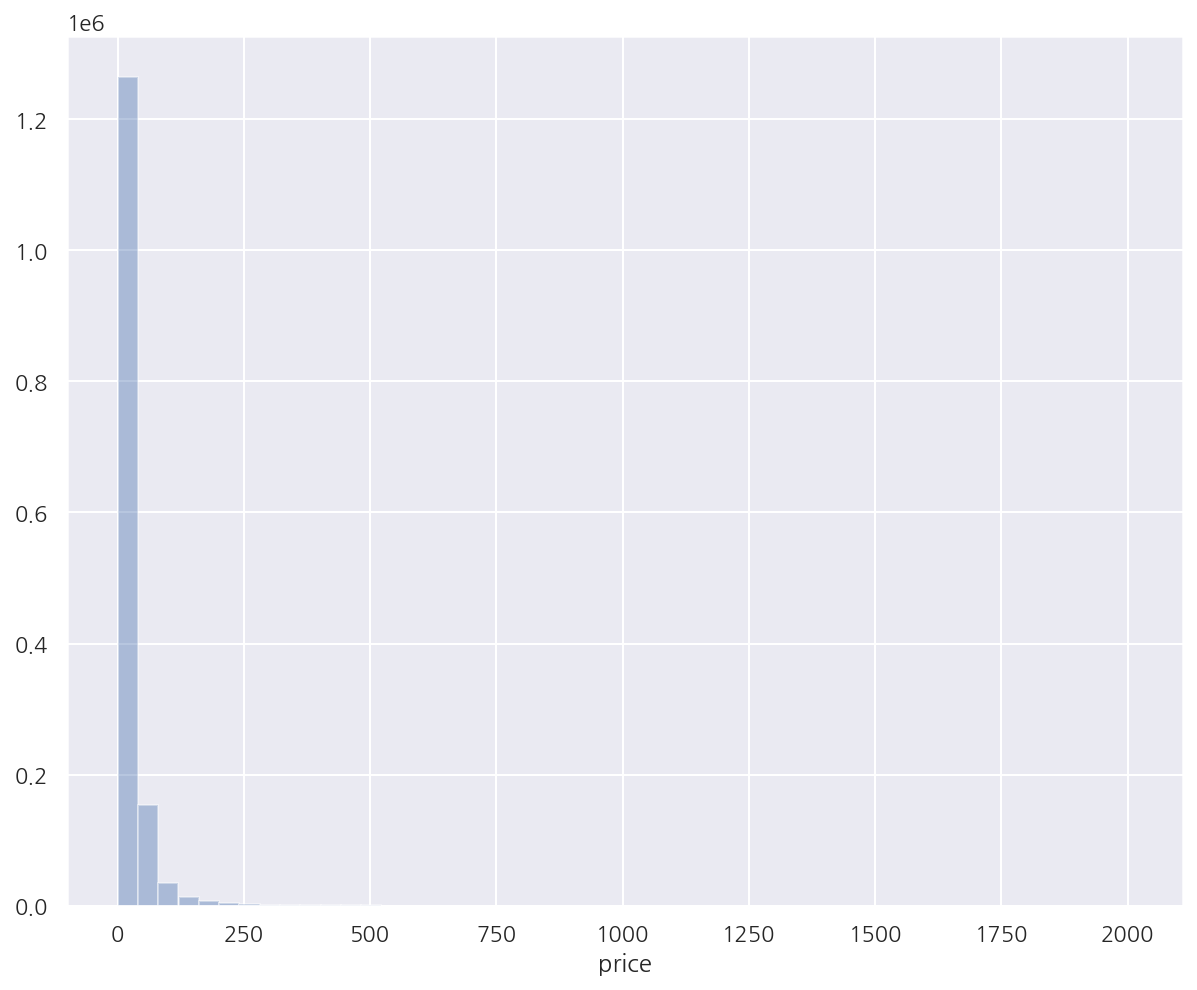

In [12]:
y_train_df = mercari_df["price"]

sns.distplot(y_train_df, kde=False)
plt.show()

- target인 price는 낮은 가격에 데이터가 치우쳐 있다.


- 로그 변환하여 살펴보자.

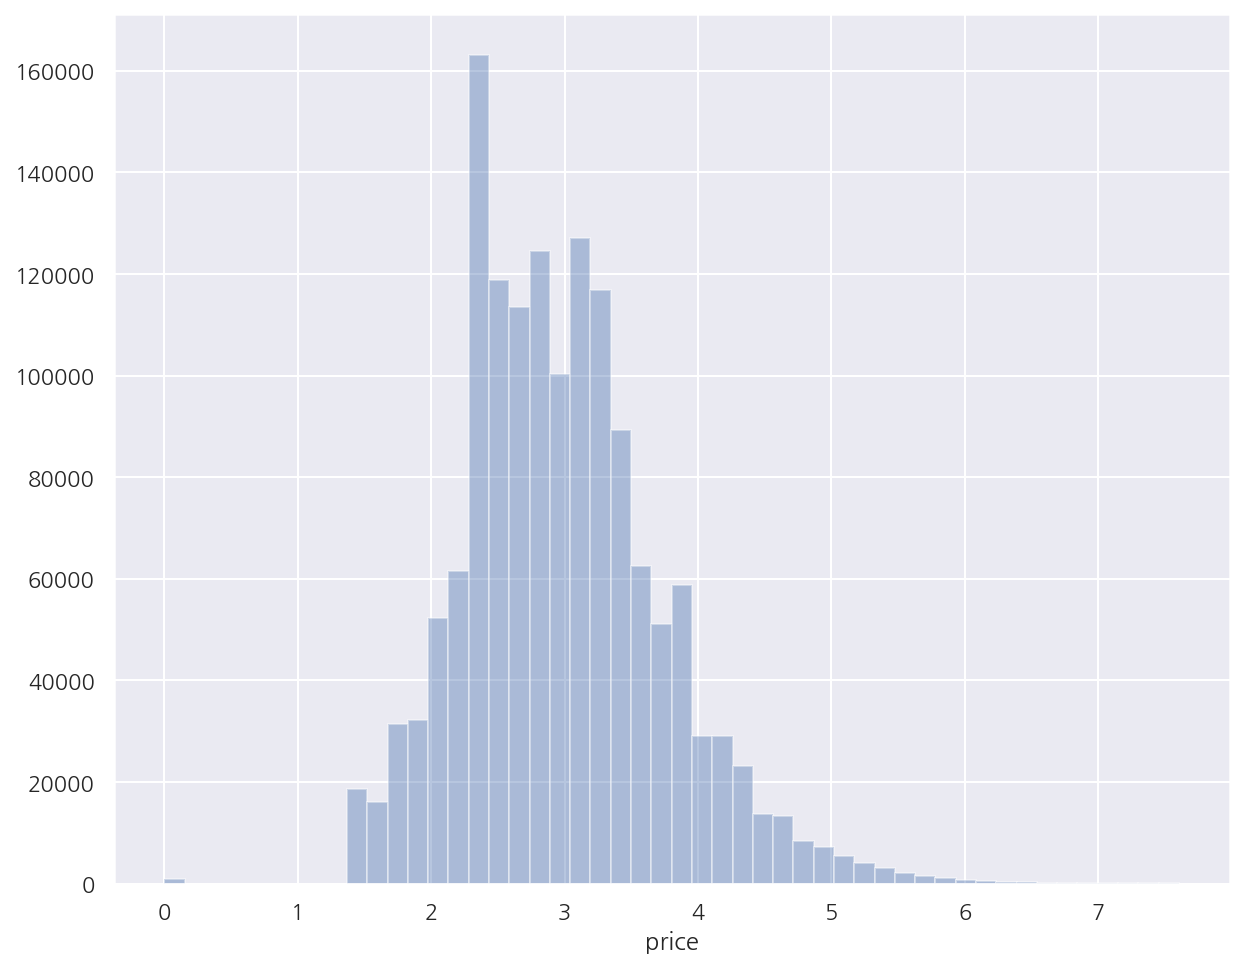

In [13]:
y_train_df = np.log1p(mercari_df["price"])

sns.distplot(y_train_df, kde=False)
plt.show()

- 로그 변환 후 비교적 정규 분포에 가까운 형태를 띈다.


- 원 데이터에서도 로그 변환값을 사용한다.

In [14]:
mercari_df['price'] = np.log1p(mercari_df['price'])
mercari_df.head(3)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,cat_dae,cat_jung,cat_so
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,Other_Null,2.397895,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,3.970292,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,2.397895,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse


## 1.2 피처 벡터화

price 예측을 위해 추후 선형 회귀와 회귀 트리를 사용할 것이다.

회귀의 경우 레이블 인코딩보다 원-핫 인코딩이 선호되므로 문자열 컬럼은 원-핫 인코딩을 적용한다.

피처 벡터화는 짧은 텍스트는 Count 벡터화, 긴 텍스트는 TF-IDF 벡터화를 진행한다.

In [15]:
# brand_name
print("brand_name 종류:", mercari_df["brand_name"].nunique())
print(mercari_df["brand_name"].value_counts()[:10])

brand_name 종류: 4810
Other_Null           632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Apple                 17322
FOREVER 21            15186
Nintendo              15007
Lululemon             14558
Michael Kors          13928
Name: brand_name, dtype: int64


- brand_name의 경우 대부분 명확한 문자열로 되어 있다.


- 종류가 4,810개로 많아 보이나 따로 피처 벡터화 없이 원-핫 인코딩으로 변환한다.


- 또한 종류가 적은 item_condition_id, shipping 역시 원-핫 인코딩으로 변환한다.


- category_name의 경우 대/중/소로 구분한 컬럼을 원-핫 인코딩으로 변환한다.

In [16]:
# name
print("name 종류:", mercari_df["name"].nunique())
print(mercari_df["name"].value_counts()[:10])

name 종류: 1225273
Bundle                 2232
Reserved                453
Converse                445
BUNDLE                  418
Dress                   410
Coach purse             404
Lularoe TC leggings     396
Romper                  353
Nike                    340
Vans                    334
Name: name, dtype: int64


- name은 종류가 1,225,273으로 전체 데이터 건수와 비슷하다(대부분 고유의 name).


- 종류는 매우 많은 반면, 텍스트 자체는 길지 않아 Count 벡터화를 진행한다.


- 반면, item_description은 가장 긴 텍스트이므로 TF-IDF 벡터화 한다.

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# name: Count 벡터화
cnt_vec = CountVectorizer()
X_name = cnt_vec.fit_transform(mercari_df["name"])

# item_description: TF-IDF 벡터화
tfidf_vec = TfidfVectorizer(max_features = 50000, ngram_range= (1,3) , stop_words='english')
X_descp = tfidf_vec.fit_transform(mercari_df['item_description'])

print('name vectorization shape:', X_name.shape)
print('item_description vectorization shape:', X_descp.shape)

name vectorization shape: (1482535, 105757)
item_description vectorization shape: (1482535, 50000)


- name은 Count 벡터화, item_description은 TF-IDF 벡터화하였다.


- item_description은 word 피처 수를 50,000개로 제한하였다.

In [18]:
X_name

<1482535x105757 sparse matrix of type '<class 'numpy.int64'>'
	with 6235725 stored elements in Compressed Sparse Row format>

- 피처 벡터화는 위와 같이 밀집 행렬이 아닌 희소 행렬로 나타난다.


- 그리고 추후 피처 벡터화, 원-핫 인코딩을 합쳐서 피처로 사용하여야한다.


- 이를 위해 원-핫 인코딩 역시 밀집 행렬이 아닌 희소 행렬 형태로 인코딩 해서 결합하도록 한다.

In [19]:
from sklearn.preprocessing import LabelBinarizer

# brand_name, item_condition_id, shipping: 희소 행렬 원-핫 인코딩 변환
lb_brand_name= LabelBinarizer(sparse_output=True)
lb_item_cond_id = LabelBinarizer(sparse_output=True)
lb_shipping= LabelBinarizer(sparse_output=True)

X_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])

# cat_dae, cat_jung, cat_so: 희소 행렬 원-핫 인코딩 변환
lb_cat_dae = LabelBinarizer(sparse_output=True)
lb_cat_jung = LabelBinarizer(sparse_output=True)
lb_cat_so = LabelBinarizer(sparse_output=True)

X_cat_dae= lb_cat_dae.fit_transform(mercari_df['cat_dae'])
X_cat_jung = lb_cat_jung.fit_transform(mercari_df['cat_jung'])
X_cat_so = lb_cat_so.fit_transform(mercari_df['cat_so'])

- `LabelBinarizer()`은 `spars_output`을 True로 설정하면 희소 행렬 형태의 원-핫 인코딩 변환을 지원한다.

In [20]:
print(type(X_brand), type(X_item_cond_id), type(X_shipping))

<class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'>


- 인코딩한 데이터는 csr_matrix 형태로 변환되었다.

In [21]:
print(f'X_brand_shape:{X_brand.shape}, X_item_cond_id shape:{X_item_cond_id.shape}')
print(f'X_shipping shape:{X_shipping.shape}, X_cat_dae shape:{X_cat_dae.shape}')
print(f'X_cat_jung shape:{X_cat_jung.shape}, X_cat_so shape:{X_cat_so.shape}')

X_brand_shape:(1482535, 4810), X_item_cond_id shape:(1482535, 5)
X_shipping shape:(1482535, 1), X_cat_dae shape:(1482535, 11)
X_cat_jung shape:(1482535, 114), X_cat_so shape:(1482535, 871)


- 각 인코딩 데이터들은 원래 컬럼들의 값 종류만큼 열을 가진다.


- shipping은 원래 2개의 값인데 열이 1개로 나와서 의아하다.


- 따로 `OneHotEncoder()`를 적용하면 2개로 나타나고, `pd.get_dummies()`로는 1개로 나타난다.


- 문제가 있는지 무언갈 모르는건지 잘 모르겠지만 우선 교재와 같으므로 그대로 진행한다.

In [22]:
from  scipy.sparse import hstack
import gc

# 희소 행렬 형태의 피처 리스트
sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id, X_shipping, 
                      X_cat_dae, X_cat_jung, X_cat_so)

# 피처 리스트 결합
X_features_sparse= hstack(sparse_matrix_list).tocsr() # tocsr()을 하지 않으면 COO 희소 행렬
print(type(X_features_sparse), X_features_sparse.shape)

# 객체 제거, 메모리에서 제거
del X_features_sparse
gc.collect()

<class 'scipy.sparse.csr.csr_matrix'> (1482535, 161569)


13388

- `scipy.sparse`의 `hstack()`을 이용해서 희소 행렬 형태의 모든 피처를 CSR 형태로 결합한다.


- 최종적으로 총 161,569개의 피처를 사용한다.


- 데이터가 많은 메모리를 잡아먹어 객체를 제거한 후 `gc.collect()`로 메모리에서 해제한다.


- 뒤에서도 계속 생성 후 바로 제거해준다.

## 1.3 Ridge 회귀

**학습/예측 함수**

In [23]:
from  scipy.sparse import hstack
import gc
from sklearn.model_selection import train_test_split

def model_train_predict(model, matrix_list):
    # 희소 행렬 결합
    X= hstack(matrix_list).tocsr()     
    
    X_train, X_test, y_train, y_test=train_test_split(X, mercari_df['price'], 
                                                      test_size=0.2, random_state=156)
    
    # 모델 학습 및 예측
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    del X , X_train , X_test , y_train 
    gc.collect()
    
    return preds , y_test

- 최종 피처를 사용해서 학습/예측을 수행하고 target과 예측값을 반환 후 메모리에서 제거한다.

**성능 평가 함수**

성능 평가로는 캐글에서 제시한 RMSLE(Root Mean Square Logarithmic Error) 방식을 사용한다.

RMSLE의 공식은 다음과 같다.

$$\epsilon = \sqrt{\dfrac{1}{n} \sum_{i}^n \left(\text{log}(p_{i}+1) - \text{log}(a_{i}+1) \right)^{2}}$$

In [24]:
def rmsle(y, y_pred):
    return np.sqrt( np.mean( ( np.log1p(y) - np.log1p(y_pred) )**2 ) )

def evaluate_org_price(y_test, preds): 
    
    # 원본 데이터는 log1p로 변환하였으므로 exmpm1으로 변환
    preds_exmpm = np.expm1(preds)
    y_test_exmpm = np.expm1(y_test)
    
    # RMSLE
    rmsle_result = rmsle(y_test_exmpm, preds_exmpm)
    return rmsle_result

- 현재 target을 로그 변환했으므로 RMSLE 계산시 다시 원래대로 변환 후 계산한다.

In [25]:
from sklearn.linear_model import Ridge

# Ridge
linear_model = Ridge(solver = "lsqr", fit_intercept=False)

# 희소 행렬 형태의 피처 리스트 (X_descp 제외)
sparse_matrix_list = (X_name, X_brand, X_item_cond_id, X_shipping, 
                      X_cat_dae, X_cat_jung, X_cat_so)

# 학습/예측/평가
linear_preds, y_test = model_train_predict(model=linear_model ,matrix_list=sparse_matrix_list)
ridge_rmsle = evaluate_org_price(y_test , linear_preds)

print(f'Item Description을 제외했을 때 rmsle 값: {ridge_rmsle:.5f}')

Item Description을 제외했을 때 rmsle 값: 0.50218


- 텍스트 데이터 item_decription을 제외하였을 때 RMSLE는 0.50218로 계산되었다.

In [26]:
# Ridge
linear_model = Ridge(solver = "lsqr", fit_intercept=False)

# 희소 행렬 형태의 피처 리스트 (전체 포함)
sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id, X_shipping, 
                      X_cat_dae, X_cat_jung, X_cat_so)

# 학습/예측/평가
linear_preds, y_test = model_train_predict(model=linear_model ,matrix_list=sparse_matrix_list)
ridge_rmsle = evaluate_org_price(y_test , linear_preds)

print(f'Item Description을 포함한 rmsle 값: {ridge_rmsle:.5f}')

Item Description을 포함한 rmsle 값: 0.47122


- 텍스트 데이터 item_decription을 포함하였을 때 RMSLE는 0.47122로 계산되었다.


- item_decription의 영향이 중요함을 알 수 있다.

## 1.4 LightGBM 회귀 트리

In [27]:
from lightgbm import LGBMRegressor

# LGBMRegressor
lgbm_model = LGBMRegressor(n_estimators=200, learning_rate=0.5, num_leaves=125, random_state=156)

# 희소 행렬 형태의 피처 리스트 (전체 포함)
sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id, X_shipping, 
                      X_cat_dae, X_cat_jung, X_cat_so)

# 학습/예측/평가
lgbm_preds , y_test = model_train_predict(model = lgbm_model , matrix_list=sparse_matrix_list)
lgbmr_rmsle = evaluate_org_price(y_test , lgbm_preds)

print(f'LightGBM rmsle 값: {lgbmr_rmsle:.5f}')

LightGBM rmsle 값: 0.45629


- LightGBM 회귀 트리로 예측하였을 때 RMSLE가 앞서 Ridge보다 낮게 나타났다.

## 1.5 앙상블 회귀

In [28]:
preds = lgbm_preds * 0.45 + linear_preds * 0.55
fin_rmsle = evaluate_org_price(y_test , preds)

print(f'LightGBM과 Ridge를 ensemble한 최종 rmsle 값: {fin_rmsle:.5f}')

LightGBM과 Ridge를 ensemble한 최종 rmsle 값: 0.45034


- 간단하게 위에서 사용한 두 모델을 혼합하여 예측 성능을 향상 시켰다.


- [회귀 분석 실습](https://romg2.github.io/mlguide/10_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-%EC%99%84%EB%B2%BD%EA%B0%80%EC%9D%B4%EB%93%9C-05.-%ED%9A%8C%EA%B7%80-%EC%8B%A4%EC%8A%B5/)에서도 사용하였던 방법이다.